In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,make_scorer, accuracy_score, f1_score, recall_score, classification_report
import seaborn as sns


In [2]:
df = pd.read_csv('dataset.csv')
pd.set_option('display.max_columns', None)
df['NewExist'] = df['NewExist'].fillna(0)

In [3]:
features_of_interest = [
    'State','cat_activites', 'UrbanRural','LowDoc','bank_loan_float','SBA_loan_float','FranchiseCode','crisis','BankState','Term','RevLineCr',
    'MIS_Status'
]

numerical_column = ['bank_loan_float','SBA_loan_float','Term'
    
]


ordinal_column = [
    'LowDoc'
]

categorical_column = [
    'State','cat_activites','FranchiseCode','BankState','RevLineCr'
]


target_name = "MIS_Status"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, target,train_size=0.9, random_state=42, stratify=data['MIS_Status'])
# Retirer la colonne 'MIS_Status' des ensembles X_train et X_test (pour éviter le data leaking)
X_train = X_train.drop('MIS_Status', axis=1)
X_test = X_test.drop('MIS_Status', axis=1)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [5]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [6]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column),

    ],
    remainder="passthrough",

)

In [13]:
xgb_class = make_pipeline(preprocessor, XGBClassifier()) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans


In [14]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [21]:
param_grid = {
    'xgbclassifier__max_depth': [7,8,9,10,20],
}

grid_search = GridSearchCV(
    xgb_class,
    param_grid,
    scoring='f1'
)


grid_search.fit(X_train, y_train_encoded)

print(grid_search.score(X_test,y_test_encoded))
print(grid_search.best_params_)


0.9683637631035684
{'xgbclassifier__max_depth': 10}


In [22]:
best_xgb_model=xgb_class.set_params(**grid_search.best_params_)

In [23]:
# xgb_class = make_pipeline(preprocessor,XGBClassifier()) # modele meilleur avec le polynomialfeatures mais pour les graphiques faire sans
best_xgb_model.fit(X_train, y_train_encoded)

/home/addeche/Documents/Projets Python/loan_classification/brief_loan/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'cat_activites',
                                                   'FranchiseCode', 'BankState',
                                                   'RevLineCr']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc']),
                                                 ('numeric', StandardScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('xgbclassifier',
                 XGB...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = best_xgb_model.predict_proba(X_test)[:, 1]
y_pred = best_xgb_model.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', best_xgb_model.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

AUC-ROC score: 0.9769899710219304
accuracy 0.947507145478608
rappel 0.8211253326574579
f1_score 0.845942946667537
              precision    recall  f1-score   support

           0       0.87      0.82      0.85     15782
           1       0.96      0.97      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



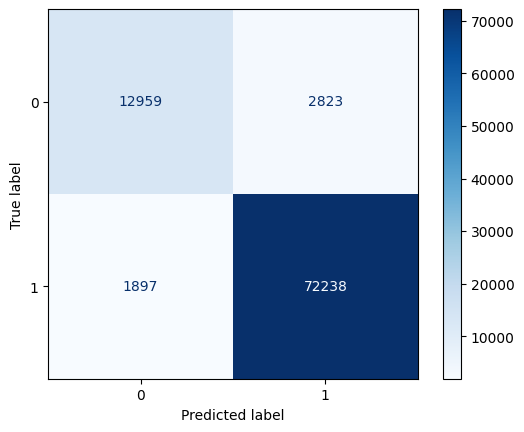

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
# Calculer la matrice de confusion
cm = confusion_matrix(y_test_encoded, y_pred)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [29]:
proba

array([0.9972926 , 0.00717011, 0.9986744 , ..., 0.9945747 , 0.9973648 ,
       0.9962993 ], shape=(89917,), dtype=float32)

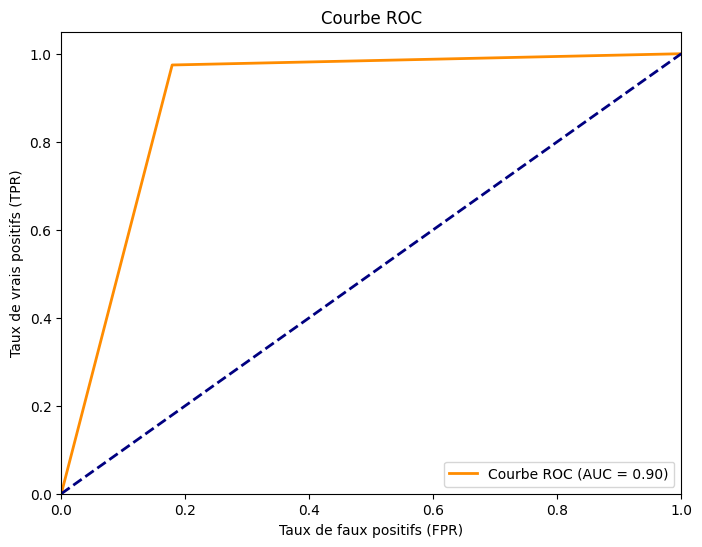

In [27]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Calculer la courbe ROC et l'AUC
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = auc(fpr, tpr)

# Dessiner la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale (aucune performance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
param_grid = {
    'xgbclassifier__max_depth': [7,8,9,10,20],
    'xgbclassifier__learning_rate': [0.3,0.4,0.5,0.6,0.7,0.75,0.8],
    'xgbclassifier__n_estimators' : [10,20,50,100],
    'xgbclassifier__min_samples_split': [5,10,25,50],
    'xgbclassifier__min_samples_leaf': [5,10,25,50],
}

rand_search = RandomizedSearchCV(
    xgb_class,
    param_grid,
    n_iter=100,
    scoring='f1'
)


rand_search.fit(X_train, y_train_encoded)

print(rand_search.score(X_test,y_test_encoded))
print(rand_search.best_params_)

/home/addeche/Documents/Projets Python/loan_classification/brief_loan/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:04:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/addeche/Documents/Projets Python/loan_classification/brief_loan/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:04:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/addeche/Documents/Projets Python/loan_classification/brief_loan/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:04:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/home/addeche/Documents/Projets Python/loan_classification/brief_loan/.venv/lib/python3.12/site-packages/xgbo

In [32]:
best_xgb_rand_model=xgb_class.set_params(**rand_search.best_params_)

In [33]:
best_xgb_rand_model.fit(X_train, y_train_encoded)

/home/addeche/Documents/Projets Python/loan_classification/brief_loan/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'cat_activites',
                                                   'FranchiseCode', 'BankState',
                                                   'RevLineCr']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['LowDoc']),
                                                 ('numeric', StandardScaler(),
                                                  ['bank_loan_float',
                                                   'SBA_loan_float',
                                                   'Term'])])),
                ('xgbclassifier',
                 XGB...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.4,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [34]:
# Si c'est un problème binaire, prenez la probabilité pour la classe 1 (classe positive)
proba = best_xgb_rand_model.predict_proba(X_test)[:, 1]
y_pred = best_xgb_rand_model.predict(X_test)
# Calcul du score AUC-ROC
roc_auc = roc_auc_score(y_test_encoded, proba)
print("AUC-ROC score:", roc_auc)
print('accuracy', best_xgb_rand_model.score(X_test,y_test_encoded))
print('rappel', recall_score(y_test_encoded,y_pred,pos_label=0))
print('f1_score',f1_score(y_test_encoded,y_pred, pos_label=0))
print(classification_report(y_test_encoded,y_pred))

AUC-ROC score: 0.9771801601432726
accuracy 0.9475738736835081
rappel 0.8206184260549994
f1_score 0.8460282205382806
              precision    recall  f1-score   support

           0       0.87      0.82      0.85     15782
           1       0.96      0.97      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



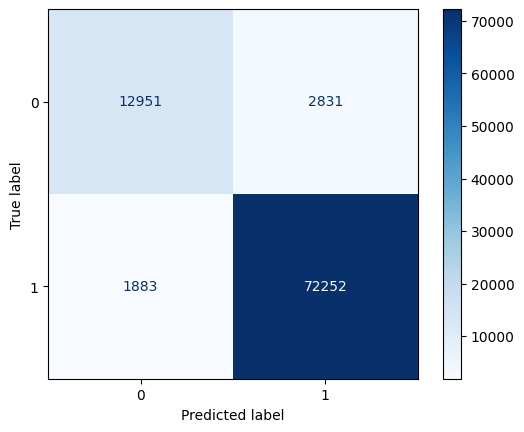

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
# Calculer la matrice de confusion
cm = confusion_matrix(y_test_encoded, y_pred)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_rand_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()